# Imports and Utils

In [330]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

In [32]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# Load Data

In [527]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")

# Depression group definitions

## Participant categories

- Severe symptoms (PHQ-9 ≥ 15)
- Moderate symptoms (PHQ-9 = 10-14)*
- Mild symptoms (PHQ-9 = 5-9)
- No symptoms (PHQ-9 < 5). 

We estimate that 30-50% of the PHQ-9 ≥ 15 group will show substantial drops of >5 points on the PHQ-9 during the study. Participants in the PHQ-9 = 5-14 range will show the maximum amount of movement in PHQ-9 scores over 4 months. We expect no substantive movement in depression among control participants with a PHQ-9 < 5.

In [528]:
group_df = phq_df[phq_df['redcap_event_name'] == 'week_0_arm_1']

def categorize_phq(x):
    if x < 5: return "no_symp"
    if x <= 9: return "mild"
    if x <= 14: return "moderate"
    if x > 14: return "severe"
    return "N/A"

group_df['baseline_group'] = group_df['phq_total_sc'].apply(categorize_phq)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [529]:
group_df['baseline_group'].value_counts()

moderate    93
severe      85
no_symp     56
mild        48
Name: baseline_group, dtype: int64

In [530]:
group_df['phq_total_sc'].describe()

count    282.000000
mean      10.932624
std        6.108078
min        0.000000
25%        6.000000
50%       11.000000
75%       15.000000
max       24.000000
Name: phq_total_sc, dtype: float64

In [531]:
phq_group_dict = {k:v for k, v in zip(group_df['pid'].values, group_df['baseline_group'].values)}

phq_df['baseline_group'] = phq_df['pid'].map(phq_group_dict)

In [532]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 4,
   "week_7_arm_1": 7,
   "week_10_arm_1": 10,
   "week_13_arm_1": 13,
   "week_16_arm_1": 16
}

phq_df['study_wk'] = phq_df['redcap_event_name'].map(event_dict)

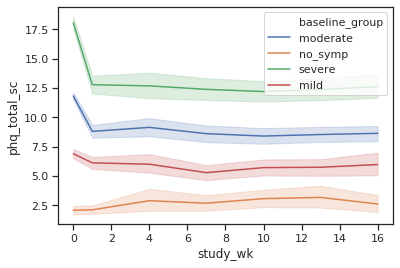

In [533]:
phq_df['phq_start'] = pd.to_datetime(phq_df['phq_start'])
sns.lineplot(x="study_wk", y="phq_total_sc", hue="baseline_group", data=phq_df)

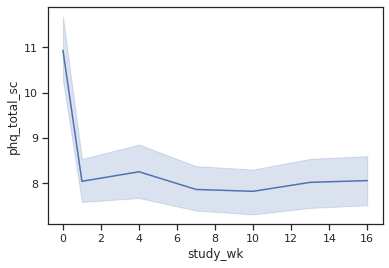

In [534]:
sns.lineplot(x="study_wk", y="phq_total_sc", data=phq_df)

In [535]:
phq_df['timestamp'] = (phq_df['phq_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

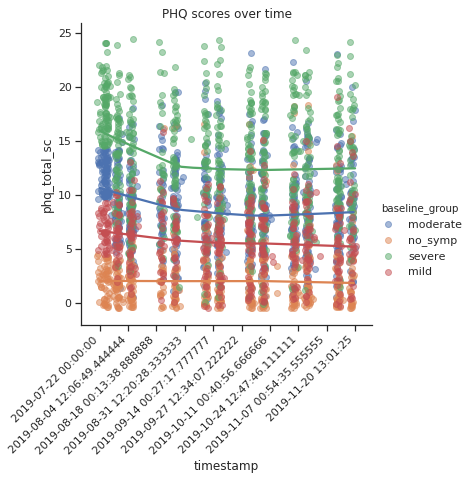

In [536]:
import matplotlib.dates as md


sns.lmplot(x='timestamp', y='phq_total_sc', 
           data=phq_df, 
           lowess=True, 
           hue="baseline_group", 
           x_jitter=100000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(phq_df['timestamp'].min(), phq_df['timestamp'].max(), 10)
idx = pd.date_range(phq_df['phq_start'].min(), phq_df['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("PHQ scores over time")
plt.show()

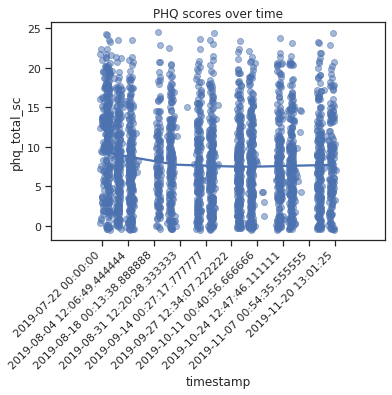

In [537]:
import matplotlib.dates as md


sns.regplot(x='timestamp', y='phq_total_sc', 
           data=phq_df, 
           lowess=True, 
           x_jitter=100000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(phq_df['timestamp'].min(), phq_df['timestamp'].max(), 10)
idx = pd.date_range(phq_df['phq_start'].min(), phq_df['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("PHQ scores over time")
plt.show()

In [538]:
phq_df[(phq_df['baseline_group'] == 'severe') & (phq_df['study_wk'] < 2)][['pid', 'phq_total_sc', 'phq_start']].head(20)

,pid,phq_total_sc,phq_start
121,01495950,15,2019-07-25 00:00:00
0,01495950,8,2019-07-30 07:57:47
0,01495950,5,2019-08-05 21:18:28
165,03384972,18,2019-07-25 00:00:00
0,03384972,15,2019-08-05 20:07:10
57,04133537,15,2019-07-23 00:00:00
0,04133537,9,2019-07-30 10:29:34
0,04133537,9,2019-08-05 16:01:48
54,05261598,18,2019-07-23 00:00:00
0,05261598,10,2019-07-30 14:56:41


In [539]:
print("Standard deviations")
phq_df.groupby('baseline_group')['phq_total_sc'].std().sort_values()

Standard deviations


baseline_group
mild        3.083363
no_symp     3.247513
moderate    3.936089
severe      5.204522
Name: phq_total_sc, dtype: float64

## Build Sequence DF

In [590]:
phq_df[phq_df['redcap_event_name'] == 'week_1_arm_1']['phq_start'].min()

Timestamp('2019-07-27 06:43:24')

In [591]:
survey_dates = [
    '2019-07-23',
    '2019-07-30',
    '2019-08-05', 
    '2019-08-20',
    '2019-08-26',
    '2019-09-10',
    '2019-09-16',
    '2019-10-01',
    '2019-10-07',
    '2019-10-21',
    '2019-10-29',
    '2019-11-11',
    '2019-11-19'
]

In [592]:
survey_idxs = []
phq_tots = []
phq_dates = []
baseline_groups = []
pids = []

for pid, group in phq_df.groupby('pid', as_index=False):

    
    for idx, date in enumerate(survey_dates):
        tot = np.nan
        phq_date = np.nan        
        sel_row = group[(group['phq_start'] > (pd.to_datetime(date) - pd.Timedelta(3, unit='D'))) & 
                        (group['phq_start'] < (pd.to_datetime(date) + pd.Timedelta(5, unit='D')))]
        #print(date)
        #display(sel_row)
        if sel_row.shape[0] > 0:
            tot = sel_row['phq_total_sc'].values[0]
            phq_date = sel_row['phq_start'].values[0]
            
        phq_tots.append(tot)
        phq_dates.append(phq_date)
        baseline_groups.append(group['baseline_group'].values[0])
        pids.append(pid)
        survey_idxs.append(idx)

In [593]:
phq_seq_df = pd.DataFrame()
phq_seq_df['pid'] = pids
phq_seq_df['baseline_group'] = baseline_groups
phq_seq_df['survey_idx'] = survey_idxs
phq_seq_df['date'] = phq_dates
phq_seq_df['phq_tot'] = phq_tots

In [594]:
color_map = {
    'no_symp': 'blue',
    'mild': 'orange',
    'moderate': 'green',
    'severe': 'red'
}

In [595]:
phq_pivot = phq_seq_df.pivot_table(index="pid", columns=['survey_idx'])

# need better imputation
phq_pivot = phq_pivot.T.fillna(phq_pivot.mean(axis=1)).T

In [596]:
print(color_map)

{'no_symp': 'blue', 'mild': 'orange', 'moderate': 'green', 'severe': 'red'}


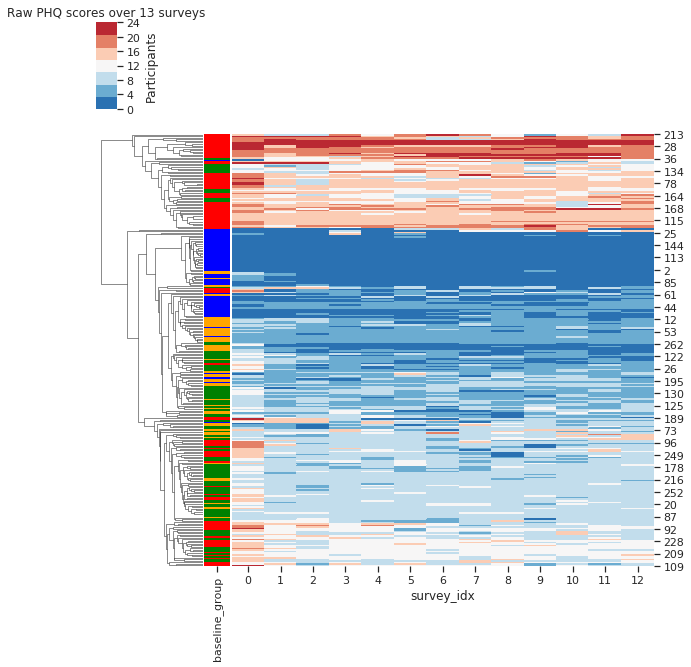

In [599]:
phq_pivot_cluster = phq_pivot.copy()
phq_pivot_cluster = phq_pivot_cluster.reset_index()
phq_pivot_cluster['baseline_group'] = phq_pivot_cluster['pid'].map(phq_group_dict)
phq_pivot_cluster = phq_pivot_cluster.drop('pid', axis='columns')

group = phq_pivot_cluster.pop("baseline_group")
row_colors = group.map(color_map)
cmap = sns.color_palette("RdBu_r", 7)

sns.clustermap(phq_pivot_cluster['phq_tot'], cmap=cmap, figsize=(10,10), 
               col_cluster=False, row_colors=row_colors)
plt.ylabel("Participants")
plt.title("Raw PHQ scores over 13 surveys")
plt.show()

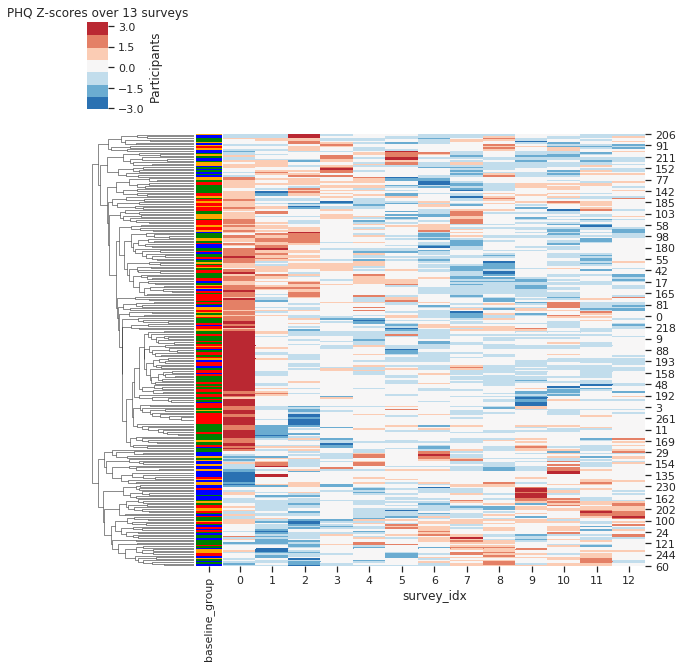

In [600]:
phq_pivot_z = phq_pivot.T
phq_pivot_z = ((phq_pivot_z - phq_pivot_z.mean())/phq_pivot_z.std()).T
phq_pivot_z = phq_pivot_z.dropna()

phq_pivot_z = phq_pivot_z.reset_index()
phq_pivot_z['baseline_group'] = phq_pivot_z['pid'].map(phq_group_dict)
phq_pivot_z = phq_pivot_z.drop('pid', axis='columns')

group = phq_pivot_z.pop("baseline_group")
row_colors = group.map(color_map)
cmap = sns.color_palette("RdBu_r", 7)

sns.clustermap(phq_pivot_z['phq_tot'], cmap=cmap, figsize=(10,10), 
               col_cluster=False, row_colors=row_colors)
plt.ylabel("Participants")
plt.title("PHQ Z-scores over 13 surveys")
plt.show()

Text(0.5, 1.0, 'Within individual PHQ variance')

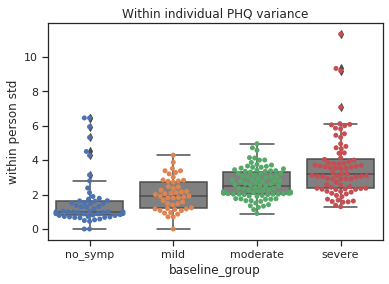

In [601]:
phq_std = phq_seq_df.groupby('pid')['phq_tot'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std['baseline_group'] = phq_std['pid'].map(phq_group_dict)
phq_std = phq_std.rename(columns={'phq_tot': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=phq_std, 
                   order=['no_symp', 'mild', 'moderate', 'severe'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=phq_std, 
                   order=['no_symp', 'mild', 'moderate', 'severe'], color=".5")
plt.title("Within individual PHQ variance")

# State Changes

## Categorical definition of improvement: 

Standard clinical threshold is 5 point on PHQ-9 for full response, however, changes of 2 and 3 are often recommend for decision making. May not be important to categorize at first, given it’s not clear.

## Transition from depressed to non depressed.

Transition from depressed to non-depressed state will use the criterion for reliable and clinically significant change validated for the PHQ-9. Depressed participants (PHQ-9 ≥ 10) who subsequently show PHQ-9<10 and a reduction of ≥ 5 will be classified as transitioning from depressed to non-depressed. Similarly, non-depressed participants (PHQ-9 < 10) that subsequently have PHQ-9 ≥ 10 and an increase of ≥ 5 will be classified as having transitioned from nondepressed to depressed. 

## Depressed to non-depressed

- defined as a change from above 10 to below 10
- with a decrease of at least 5 points (and vice versa)

In [550]:
phq_pivot = phq_seq_df.pivot_table(index="pid", columns=['survey_idx'])

In [551]:
phq_pivot.head()

phq_tot                                               
survey_idx       0     1     2     3    4     5     6     7     8
pid                                                              
00746649      12.0  13.0   7.0   NaN  9.0  12.0   7.0   6.0   9.0
01225297      10.0   7.0  10.0   NaN  NaN   NaN   NaN   7.0   NaN
01254121       0.0   1.0   1.0   0.0  0.0   NaN   0.0   0.0   1.0
01495950      15.0   8.0   5.0   6.0  8.0  12.0   NaN   8.0   7.0
01766910      12.0  13.0  13.0  12.0  NaN  12.0  12.0  10.0  13.0

# Correlates Over Time

## Load data

In [603]:
# load cal data
all_cal = pd.read_pickle("ls_data/all_cal.df")
all_cal = all_cal.rename(columns={'call_hour': 'hour'})
all_cal.head()
all_cal = all_cal[(all_cal['hour'] < '2019-08-13') & (all_cal['hour'] >= '2019-07-20')]

wk4_cal = pd.read_pickle("ls_data/wk4/cal_hr.df")
wk7_cal = pd.read_pickle("ls_data/wk7/cal_hr.df")
wk10_cal = pd.read_pickle("ls_data/wk10/cal_hr.df")
wk13_cal = pd.read_pickle("ls_data/wk13/cal_hr.df")
wk16_cal = pd.read_pickle("ls_data/wk16/cal_hr.df")


all_cal = all_cal.append(wk4_cal)
all_cal = all_cal.append(wk7_cal)
all_cal = all_cal.append(wk10_cal)
all_cal = all_cal.append(wk13_cal)
all_cal = all_cal.append(wk16_cal)


# build cal_daily
all_cal['date'] = all_cal['hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily["is_wkday"] = (pd.to_datetime(cal_daily['date']).dt.dayofweek < 5).astype(float)

display(cal_daily.head())

,pid,date,tot_call_count,tot_call_duration,is_wkday
0,00746649,2019-07-23,12,1814,1.0
1,00746649,2019-07-24,15,4572,1.0
2,00746649,2019-07-25,20,2363,1.0
3,00746649,2019-07-26,15,8063,1.0
4,00746649,2019-07-27,10,1748,0.0


In [604]:
# load sms data
all_sms = pd.read_pickle("ls_data/all_sms.df")
all_sms = all_sms.rename(columns={'sms_hour': 'hour'})
all_sms = all_sms[(all_sms['hour'] < '2019-08-13') & (all_sms['hour'] >= '2019-07-20')]

wk4_sms = pd.read_pickle("ls_data/wk4/sms_hr.df")
wk7_sms = pd.read_pickle("ls_data/wk7/sms_hr.df")
wk10_sms = pd.read_pickle("ls_data/wk10/sms_hr.df")
wk13_sms = pd.read_pickle("ls_data/wk13/sms_hr.df")
wk16_sms = pd.read_pickle("ls_data/wk16/sms_hr.df")

all_sms = all_sms.append(wk4_sms)
all_sms = all_sms.append(wk7_sms)
all_sms = all_sms.append(wk10_sms)
all_sms = all_sms.append(wk13_sms)
all_sms = all_sms.append(wk16_sms)

display(all_sms.head())

# build sms_daily
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()
sms_daily["is_wkday"] = (pd.to_datetime(sms_daily['date']).dt.dayofweek < 5).astype(float)

display(sms_daily.head())

,hour,tot_sms_count,tot_sms_length,in_sms_count,in_sms_length,out_sms_count,out_sms_length,pid
0,2019-07-27 21:00:00,6,192,4.0,105.0,2.0,87.0,08343773
1,2019-07-27 22:00:00,0,0,0.0,0.0,0.0,0.0,08343773
2,2019-07-27 23:00:00,0,0,0.0,0.0,0.0,0.0,08343773
3,2019-07-28 00:00:00,0,0,0.0,0.0,0.0,0.0,08343773
4,2019-07-28 01:00:00,0,0,0.0,0.0,0.0,0.0,08343773


,pid,date,tot_sms_count,tot_sms_length,in_sms_count,in_sms_length,out_sms_count,out_sms_length,is_wkday
0,00746649,2019-07-23,22,1738,22.0,1738.0,0.0,0.0,1.0
1,00746649,2019-07-24,24,1464,24.0,1464.0,0.0,0.0,1.0
2,00746649,2019-07-25,14,936,14.0,936.0,0.0,0.0,1.0
3,00746649,2019-07-26,23,2135,23.0,2135.0,0.0,0.0,1.0
4,00746649,2019-07-27,21,990,21.0,990.0,0.0,0.0,0.0


In [605]:
# load fga data
all_fga = pd.read_pickle("ls_data/all_fga.df")
all_fga = all_fga[(all_fga['hr'] < '2019-08-13') & (all_fga['hr'] >= '2019-07-20')]

wk4_fga = pd.read_pickle("ls_data/wk4/fga_hr.df")
wk7_fga = pd.read_pickle("ls_data/wk7/fga_hr.df")
wk10_fga = pd.read_pickle("ls_data/wk10/fga_hr.df")
wk13_fga = pd.read_pickle("ls_data/wk13/fga_hr.df")
wk16_fga = pd.read_pickle("ls_data/wk16/fga_hr.df")

all_fga = all_fga.append(wk4_fga)
all_fga = all_fga.append(wk7_fga)
all_fga = all_fga.append(wk10_fga)
all_fga = all_fga.append(wk13_fga)
all_fga = all_fga.append(wk16_fga)

display(all_fga.head())

# build fga_daily
all_fga['date'] = all_fga['hr'].dt.floor('d')
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)

display(fga_daily.head())

,hr,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,pid
0,2019-07-27 12:00:00,1771.0,0.0,0.0,105.0,0.0,0.0,405.0,0.0,0.0,0.0,0.0,08343773
1,2019-07-27 13:00:00,1336.0,0.0,0.0,255.0,315.0,0.0,195.0,0.0,0.0,0.0,0.0,08343773
2,2019-07-27 14:00:00,1666.0,0.0,0.0,180.0,0.0,0.0,330.0,0.0,0.0,0.0,0.0,08343773
3,2019-07-27 15:00:00,1997.0,0.0,0.0,309.0,165.0,0.0,195.0,0.0,60.0,0.0,0.0,08343773
4,2019-07-27 16:00:00,1289.0,0.0,0.0,379.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0,08343773


,pid,date,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,is_wkday
0,00746649,2019-07-23,0.0,0.0,3380.0,1753.0,1490.0,1113.0,211.0,1080.0,240.0,0.0,165.0,1.0
1,00746649,2019-07-24,0.0,105.0,1888.0,2831.0,965.0,713.0,1203.0,0.0,0.0,0.0,931.0,1.0
2,00746649,2019-07-25,0.0,135.0,5835.0,1826.0,98.0,770.0,368.0,0.0,73.0,0.0,509.0,1.0
3,00746649,2019-07-26,0.0,301.0,5288.0,1986.0,195.0,1362.0,842.0,0.0,1410.0,0.0,1065.0,1.0
4,00746649,2019-07-27,0.0,0.0,3166.0,686.0,0.0,110.0,3310.0,0.0,847.0,0.0,0.0,0.0


In [607]:
# load fus data
all_fus = pd.read_pickle("ls_data/fus_daily.df")
display(all_fus.head())
all_fus = all_fus[(all_fus['date'] < '2019-08-13') & (all_fus['date'] >= '2019-07-20')]

wk4_fus = pd.read_pickle("ls_data/wk4/fus_daily.df")
wk7_fus = pd.read_pickle("ls_data/wk7/fus_daily.df")
wk10_fus = pd.read_pickle("ls_data/wk10/fus_daily.df")
wk13_fus = pd.read_pickle("ls_data/wk13/fus_daily.df")
wk16_fus = pd.read_pickle("ls_data/wk16/fus_daily.df")


all_fus = all_fus.append(wk4_fus)
all_fus = all_fus.append(wk7_fus)
all_fus = all_fus.append(wk10_fus)
all_fus = all_fus.append(wk13_fus)
all_fus = all_fus.append(wk16_fus)

display(all_fus.head())

# build fus_daily
fus_daily = all_fus.copy()
fus_daily["is_wkday"] = (pd.to_datetime(fus_daily['date']).dt.dayofweek < 5).astype(float)

,pid,date,dist,entropy,cluster,loc_var,velocity,norm_entropy,is_wkday
3,08343773,2019-07-30,85.911460,0.929294,3,-6.661614,5.252450,0.670344,1.0
4,08343773,2019-07-31,36.688011,0.692502,3,-6.661614,1.730937,0.499535,1.0
5,08343773,2019-08-01,29.716842,0.689384,3,-6.661614,1.890282,0.497286,1.0
6,08343773,2019-08-02,35.859320,0.187561,3,-6.661614,1.915279,0.135296,1.0
7,08343773,2019-08-03,18.821381,-0.000000,3,-6.661614,0.968159,-0.000000,0.0


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,cluster,date,dist,entropy,is_wkday,loc_var,norm_entropy,pid,velocity
3,3,2019-07-30,85.911460,0.929294,1.0,-6.661614,0.670344,08343773,5.252450
4,3,2019-07-31,36.688011,0.692502,1.0,-6.661614,0.499535,08343773,1.730937
5,3,2019-08-01,29.716842,0.689384,1.0,-6.661614,0.497286,08343773,1.890282
6,3,2019-08-02,35.859320,0.187561,1.0,-6.661614,0.135296,08343773,1.915279
7,3,2019-08-03,18.821381,-0.000000,0.0,-6.661614,-0.000000,08343773,0.968159


In [674]:
# load circ data
all_circ = pd.read_pickle("ls_data/circ_movt.df")
display(all_circ.head())
#all_circ = all_circ[(all_circ['date'] < '2019-08-13') & (all_circ['date'] >= '2019-07-20')]
all_circ['wk_idx'] = 0

wk4_circ = pd.read_pickle("ls_data/wk4/circ_movt.df")
wk7_circ = pd.read_pickle("ls_data/wk7/circ_movt.df")
wk10_circ = pd.read_pickle("ls_data/wk10/circ_movt.df")
wk13_circ = pd.read_pickle("ls_data/wk13/circ_movt.df")
wk16_circ = pd.read_pickle("ls_data/wk16/circ_movt.df")

circ_dfs = [wk4_circ, 
            wk7_circ,
            wk10_circ,
            wk13_circ,
            wk16_circ]

for idx, df in enumerate(circ_dfs):
    df['wk_idx'] = idx+1
    all_circ = all_circ.append(df)

#all_circ = all_circ.append(wk4_circ)
#all_circ = all_circ.append(wk7_circ)
#all_circ = all_circ.append(wk10_circ)

display(all_circ.tail())

,pid,circ_movt_tot,circ_movt_wkday,circ_movt_wkend
0,08343773,1.309409,1.713618,2.383230
0,18583649,1.194895,1.529306,2.468502
0,99050875,1.933054,2.235061,3.232048
0,31456993,1.138472,1.522650,2.259386
0,01495950,1.544075,1.853465,2.851324


,pid,circ_movt_tot,circ_movt_wkday,circ_movt_wkend,wk_idx
0,73916801,2.747272,2.897326,4.783875,5
0,03233601,1.440295,1.749024,2.851877,5
0,62375942,1.175801,1.518448,2.448131,5
0,22352222,1.423715,1.772818,2.741219,5
0,21150752,1.302306,1.568057,2.788703,5


## Build Sequence DF

In [609]:
def build_col_dict(cols, feat_df, transform_log=True):
    """Builds a (col, [vals]) dictionary for the given features
    
    Currently looks at a 7 day window around each survey
    """
    col_dict = {}


    for col in cols:
        col_dict[col] = []

    for idx, row in phq_seq_df.iterrows():
        if pd.isna(row['phq_tot']):
            for col in cols:
                col_dict[col].append(np.nan)
            continue
        else:
            date = row['date']
            pid = row['pid']
            sel_df =  feat_df[(feat_df['pid'] == pid) &
                              # TODO double check that this is the date range we want
                             (feat_df['date'] >= (date.floor('D') - pd.Timedelta(3, unit='D'))) & 
                             (feat_df['date'] <= (date.floor('D') + pd.Timedelta(3, unit='D')))]
            sel_mean = sel_df.mean()
            
            if transform_log: sel_mean = np.log(sel_mean + 1)
            for col in cols:
                col_dict[col].append(sel_mean[col])
                
    return col_dict

In [610]:
# columns
sms_cols = ['tot_sms_count', 'tot_sms_length', 'in_sms_count', 'in_sms_length', 'out_sms_count', 'out_sms_length']

cal_cols = ['tot_call_count', 'tot_call_duration']

fus_cols = ['cluster', 'dist', 'entropy', 'loc_var', 'norm_entropy', 'velocity']

fga_cols = ['katana', 'orca', 'messaging', 'launcher', 'chrome', 'email', 'instagram', 'youtube', 'maps', 'snapchat', 'browser']

In [611]:
%%time

sms_dict = build_col_dict(sms_cols, sms_daily)

CPU times: user 14.6 s, sys: 1.23 ms, total: 14.6 s
Wall time: 14.6 s


In [612]:
%%time

cal_dict = build_col_dict(cal_cols, cal_daily)

CPU times: user 13.4 s, sys: 0 ns, total: 13.4 s
Wall time: 13.4 s


In [613]:
%%time

fus_dict = build_col_dict(fus_cols, fus_daily)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


CPU times: user 14 s, sys: 0 ns, total: 14 s
Wall time: 14 s


In [614]:
%%time

fga_dict = build_col_dict(fga_cols, fga_daily)

CPU times: user 17.5 s, sys: 40 ms, total: 17.5 s
Wall time: 16.2 s


In [615]:
corr_seq_df = phq_seq_df.copy()

sensor_dicts = [sms_dict, cal_dict, fus_dict, fga_dict]

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        corr_seq_df[col] = vals
    
corr_seq_df = corr_seq_df.replace([np.inf, -np.inf], np.nan)

corr_seq_df.head()

,pid,baseline_group,survey_idx,date,phq_tot,tot_sms_count,tot_sms_length,in_sms_count,in_sms_length,out_sms_count,...,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser
0,00746649,moderate,0,2019-07-22 00:00:00,12.0,3.044522,7.230080,3.044522,7.230080,0.000000,...,4.394449,8.216628,7.667470,6.747587,6.764270,6.388561,5.888878,4.657130,0.0,6.284134
1,00746649,moderate,1,2019-07-30 12:31:50,13.0,3.002850,7.294668,3.002850,7.294668,0.000000,...,5.559032,7.852883,7.201703,5.111988,5.548520,7.306340,5.023881,7.312935,0.0,6.989467
2,00746649,moderate,2,2019-08-05 23:32:00,7.0,1.838279,6.106705,1.838279,6.106705,0.000000,...,3.362358,7.626013,5.778536,4.643016,5.417369,6.184149,3.433987,6.837639,0.0,7.193793
3,00746649,moderate,3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00746649,moderate,4,2019-08-26 19:04:10,9.0,2.913902,7.284429,2.906120,7.280796,0.133531,...,4.439284,7.836088,6.291569,6.325638,6.339099,5.373955,4.759729,5.441799,0.0,6.433858


In [616]:
corr_seq_df['survey_idx'].max()

12

In [617]:
idx0_df = corr_seq_df[corr_seq_df['survey_idx'] == 0]
idx0_dict = {k: v for k,v in zip(idx0_df['pid'].values, idx0_df['phq_tot'])}

corr_seq_df['0_phq'] = corr_seq_df['pid'].map(idx0_dict)

In [618]:
idx8_df = corr_seq_df[corr_seq_df['survey_idx'] == 8]
idx8_dict = {k: v for k,v in zip(idx8_df['pid'].values, idx8_df['phq_tot'])}

corr_seq_df['8_phq'] = corr_seq_df['pid'].map(idx8_dict)

## Correlations over time

In [619]:
import importlib
importlib.reload(pg)

<module 'pingouin' from '/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/__init__.py'>

In [642]:
%%time

sensor_cols = sms_cols + cal_cols + fus_cols + fga_cols

pair0_df = pd.DataFrame()
for idx in range(13):
    sel_df = corr_seq_df[corr_seq_df['survey_idx'] == idx]
    sel_df = sel_df.dropna(subset=['date'])
    sel_df = sel_df[['0_phq'] + sensor_cols]
    df = pg.pairwise_corr(sel_df, columns=[sensor_cols, ['0_phq']], padjust="fdr_bh")
    df['idx'] = idx
    pair0_df = pair0_df.append(df)

CPU times: user 4.99 s, sys: 8.85 ms, total: 5 s
Wall time: 5 s


In [643]:
%%time

sensor_cols = sms_cols + cal_cols + fga_cols #+ fus_cols
pair8_df = pd.DataFrame()
for idx in range(13):
    sel_df = corr_seq_df[corr_seq_df['survey_idx'] == idx]
    sel_df = sel_df.dropna(subset=['date'])
    sel_df = sel_df[['8_phq'] + sensor_cols]
    #display(sel_df)
    df = pg.pairwise_corr(sel_df, columns=[sensor_cols, ['8_phq']], padjust="fdr_bh")
    df['idx'] = idx
    pair8_df = pair8_df.append(df)

CPU times: user 4.65 s, sys: 0 ns, total: 4.65 s
Wall time: 4.64 s


In [659]:
%%time

sensor_cols = sms_cols + cal_cols + fga_cols + fus_cols
pair_df = pd.DataFrame()
for idx in range(13):
    sel_df = corr_seq_df[corr_seq_df['survey_idx'] == idx]
    sel_df = sel_df.dropna(subset=['date'])
    sel_df = sel_df[['phq_tot'] + sensor_cols]
    #display(sel_df)
    df = pg.pairwise_corr(sel_df, columns=[sensor_cols, ['phq_tot']], padjust="fdr_bh")
    df['idx'] = idx
    pair_df = pair_df.append(df)

CPU times: user 4.94 s, sys: 9.26 ms, total: 4.95 s
Wall time: 4.94 s


In [660]:
def plot_over_time(cols, df, title):
    for col in cols:
        cal_pairs = df[df['X'] == col]
        errs = np.concatenate(cal_pairs['CI95%'].values).reshape(len(cal_pairs['r'].values),2).T
        #print(len(cal_pairs['r'].values))
        errs = errs - cal_pairs['r'].values
        errs = np.abs(errs)
        #errs = np.flip(errs,0)
        plt.errorbar(x=cal_pairs['idx'], y=cal_pairs['r'], yerr=errs, label=col, capsize=5)
    plt.axhline(y=0, ls='--')
    plt.xlabel("survey idx")
    plt.title(title)
    plt.legend()
    plt.show()

## Calls

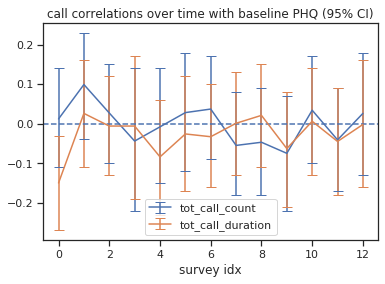

In [661]:
plot_over_time(cal_cols, pair0_df, "call correlations over time with baseline PHQ (95% CI)")

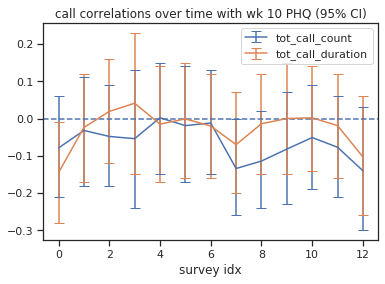

In [662]:
plot_over_time(cal_cols, pair8_df, "call correlations over time with wk 10 PHQ (95% CI)")

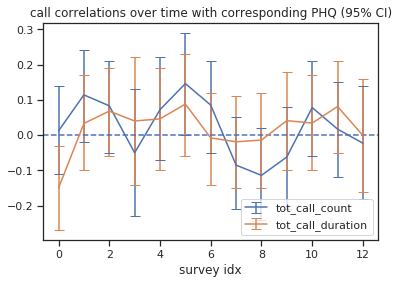

In [663]:
plot_over_time(cal_cols, pair_df, "call correlations over time with corresponding PHQ (95% CI)")

## SMS

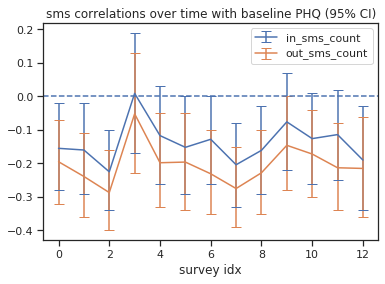

In [664]:
plot_over_time(['in_sms_count', 'out_sms_count'], pair0_df, "sms correlations over time with baseline PHQ (95% CI)")

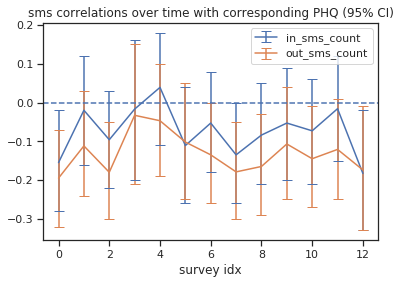

In [665]:
plot_over_time(['in_sms_count', 'out_sms_count'], pair_df, "sms correlations over time with corresponding PHQ (95% CI)")

## Apps

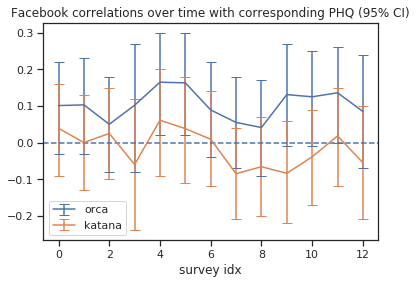

In [666]:
plot_over_time(['orca', 'katana'], pair_df, "Facebook correlations over time with corresponding PHQ (95% CI)")

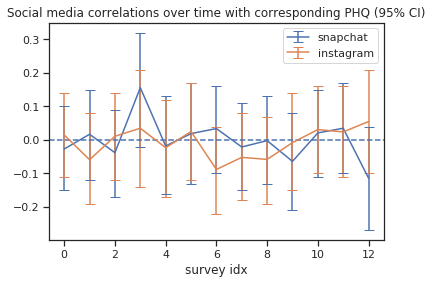

In [667]:
plot_over_time(['snapchat', 'instagram'], pair_df, "Social media correlations over time with corresponding PHQ (95% CI)")

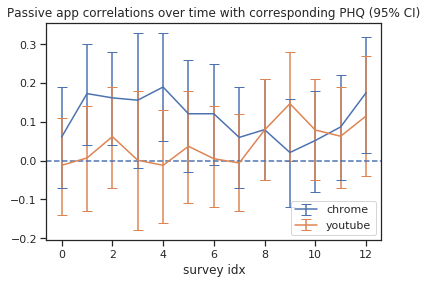

In [668]:
plot_over_time(['chrome', 'youtube'], pair_df, "Passive app correlations over time with corresponding PHQ (95% CI)")

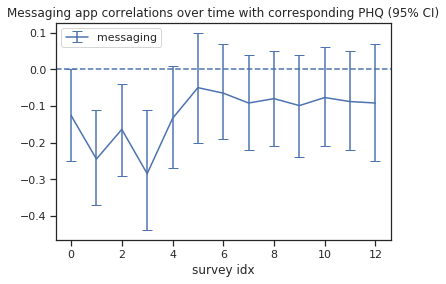

In [669]:
plot_over_time(['messaging'], pair_df, "Messaging app correlations over time with corresponding PHQ (95% CI)")

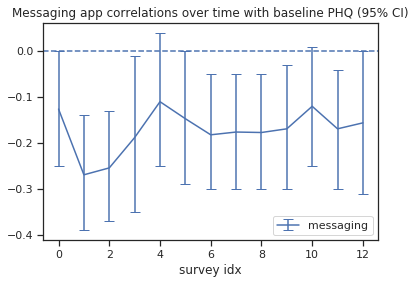

In [670]:
plot_over_time(['messaging'], pair0_df, "Messaging app correlations over time with baseline PHQ (95% CI)")

## Location

In [677]:
pair0_df

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
0,tot_sms_count,0_phq,pearson,two-sided,224,-0.178,"[-0.3, -0.05]",0.032,0.023,-0.180,0.007511,0.090127,fdr_bh,2.911,0.765,0
1,tot_sms_length,0_phq,pearson,two-sided,224,-0.147,"[-0.27, -0.02]",0.022,0.013,-0.148,0.027435,0.111469,fdr_bh,0.937,0.599,0
2,in_sms_count,0_phq,pearson,two-sided,224,-0.155,"[-0.28, -0.02]",0.024,0.015,-0.156,0.020547,0.111469,fdr_bh,1.201,0.642,0
3,in_sms_length,0_phq,pearson,two-sided,224,-0.091,"[-0.22, 0.04]",0.008,-0.001,-0.091,0.172610,0.319502,fdr_bh,0.211,0.277,0
4,out_sms_count,0_phq,pearson,two-sided,224,-0.195,"[-0.32, -0.07]",0.038,0.029,-0.198,0.003466,0.083195,fdr_bh,5.828,0.835,0
5,out_sms_length,0_phq,pearson,two-sided,224,-0.127,"[-0.25, 0.0]",0.016,0.007,-0.128,0.058041,0.174123,fdr_bh,0.498,0.476,0
6,tot_call_count,0_phq,pearson,two-sided,253,0.012,"[-0.11, 0.14]",0.000,-0.008,0.012,0.849477,0.855487,fdr_bh,0.08,0.054,0
7,tot_call_duration,0_phq,pearson,two-sided,253,-0.150,"[-0.27, -0.03]",0.022,0.015,-0.151,0.017086,0.111469,fdr_bh,1.33,0.667,0
8,cluster,0_phq,pearson,two-sided,5,0.536,"[-0.66, 0.96]",0.287,-0.426,0.599,0.352055,0.497019,fdr_bh,0.778,0.162,0
9,dist,0_phq,pearson,two-sided,5,0.767,"[-0.36, 0.98]",0.589,0.178,1.013,0.129895,0.311748,fdr_bh,1.382,0.357,0


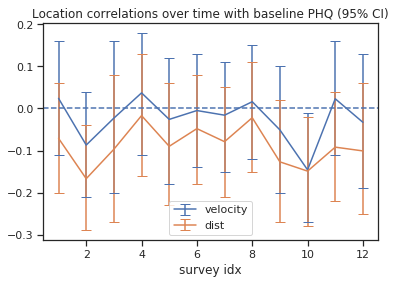

In [678]:
sel = pair0_df[pair0_df['idx'] != 0]
plot_over_time(['velocity', 'dist'], sel, "Location correlations over time with baseline PHQ (95% CI)")

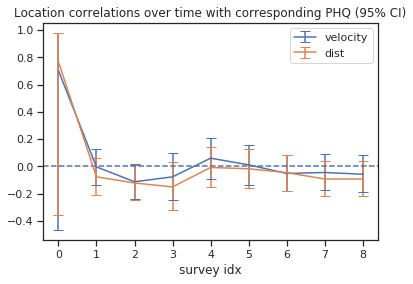

In [657]:
plot_over_time(['velocity', 'dist'], pair_df, "Location correlations over time with corresponding PHQ (95% CI)")

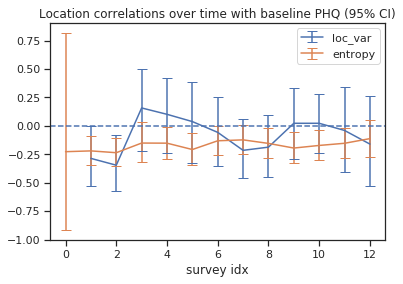

In [658]:
plot_over_time(['loc_var', 'entropy'], pair0_df, "Location correlations over time with baseline PHQ (95% CI)")

## Repeated Measures Correlation

Rmcorr accounts for non-independence among observations using analysis of covariance (ANCOVA) to statistically adjust for inter-individual variability. By removing measured variance between-participants, rmcorr provides the best linear fit for each participant using parallel regression lines (the same slope) with varying intercepts. Like a Pearson correlation coefficient, the rmcorr coefficient is bounded by − 1 to 1 and represents the strength of the linear association between two variables.

In [637]:
corr_seq_df

,pid,baseline_group,survey_idx,date,phq_tot,tot_sms_count,tot_sms_length,in_sms_count,in_sms_length,out_sms_count,...,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,0_phq,8_phq
0,00746649,moderate,0,2019-07-22 00:00:00,12.0,3.044522,7.230080,3.044522,7.230080,0.000000,...,7.667470,6.747587,6.764270,6.388561,5.888878,4.657130,0.000000,6.284134,12.0,9.0
1,00746649,moderate,1,2019-07-30 12:31:50,13.0,3.002850,7.294668,3.002850,7.294668,0.000000,...,7.201703,5.111988,5.548520,7.306340,5.023881,7.312935,0.000000,6.989467,12.0,9.0
2,00746649,moderate,2,2019-08-05 23:32:00,7.0,1.838279,6.106705,1.838279,6.106705,0.000000,...,5.778536,4.643016,5.417369,6.184149,3.433987,6.837639,0.000000,7.193793,12.0,9.0
3,00746649,moderate,3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,9.0
4,00746649,moderate,4,2019-08-26 19:04:10,9.0,2.913902,7.284429,2.906120,7.280796,0.133531,...,6.291569,6.325638,6.339099,5.373955,4.759729,5.441799,0.000000,6.433858,12.0,9.0
5,00746649,moderate,5,2019-09-10 14:28:31,12.0,3.183989,7.493874,3.183989,7.493874,0.000000,...,6.567275,6.421622,6.552915,4.330733,5.476464,6.067102,0.000000,6.978480,12.0,9.0
6,00746649,moderate,6,2019-09-16 19:08:22,7.0,2.981344,7.256196,2.981344,7.256196,0.000000,...,6.767836,6.601812,6.299999,5.481829,5.961373,6.603750,0.000000,6.814072,12.0,9.0
7,00746649,moderate,7,2019-10-01 10:53:03,6.0,3.172084,7.217024,3.172084,7.217024,0.000000,...,6.266929,6.707910,6.288124,5.470468,0.000000,5.324403,0.000000,6.881265,12.0,9.0
8,00746649,moderate,8,2019-10-07 21:55:19,9.0,2.906120,7.394932,2.906120,7.394932,0.000000,...,6.043650,6.214037,5.989677,5.152465,8.017684,5.310387,0.000000,6.676904,12.0,9.0
9,00746649,moderate,9,2019-10-22 13:02:22,9.0,3.077970,7.352807,3.077970,7.352807,0.000000,...,6.583014,6.208015,5.986093,5.074281,5.556276,4.629166,0.000000,6.984319,12.0,9.0


In [638]:
import pingouin as pg

rm_corr_df = pd.DataFrame()
for col in sensor_cols:
    df = pg.rm_corr(data=corr_seq_df, x=col, y='phq_tot', subject='pid')
    df['feat'] = col
    rm_corr_df = rm_corr_df.append(df)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c

In [672]:
rm_corr_df[(rm_corr_df['pval'] < 0.01) & (rm_corr_df['feat'] != 'loc_var')]

,r,dof,pval,CI95%,power,feat
rm_corr,-0.056,2361,0.006605,"[-0.1, -0.02]",0.776,maps
rm_corr,-0.078,2114,0.000325,"[-0.12, -0.04]",0.949,cluster
rm_corr,-0.073,2114,0.000717,"[-0.12, -0.03]",0.923,dist
rm_corr,-0.059,2057,0.007681,"[-0.1, -0.02]",0.760,velocity


In [675]:
corr_df = pd.DataFrame()
for col in ['maps', 'cluster', 'dist', 'velocity']:
    df = pg.corr(corr_seq_df[col], corr_seq_df['phq_tot'], method='spearman')
    df['feat'] = col
    corr_df = corr_df.append(df)

In [676]:
corr_df.head()

,n,r,CI95%,r2,adj_r2,p-val,power,feat
spearman,2638,-0.057,"[-0.1, -0.02]",0.003,0.002,3.379183e-03,0.834,maps
spearman,2387,-0.131,"[-0.17, -0.09]",0.017,0.016,1.266903e-10,1.000,cluster
spearman,2387,-0.064,"[-0.1, -0.02]",0.004,0.003,1.732096e-03,0.880,dist
spearman,2329,-0.030,"[-0.07, 0.01]",0.001,0.000,1.491912e-01,0.303,velocity


# TODOs

- ~~correlations with baseline/week 10 readings~~
- correlations with transitions, within person ("categorical histogram" here?)
- load scr df
- ~~within person correlations with error bars (not over time)~~